<a href="https://colab.research.google.com/github/SarahBarbosa/AluraDataChallenge_2/blob/main/S02_Feature_Engineering_e_Modelo_de_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://imgur.com/QnT31vZ.png)

---

# Sobre o desafio

Na semana 02, vamos focar na construção e otimização de modelos de machine learning (ML) para lidar com a Taxa de Churn. Agora que terminamos a limpeza e análise inicial dos dados na semana 01, é hora de usar algoritmos de ML para transformar nossos insights em ações eficazes.

## Configurando o ambiente

In [1]:
%%capture
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Github/AluraDataChallenge_2')

## Carregando os dados tratados na Semana 01

In [2]:
import pandas as pd

DIRETORIO_BASE = '/content/drive/MyDrive/Github/AluraDataChallenge_2/'
DIRETORIO_DADOS = DIRETORIO_BASE + 'Dados/'

dados_novexus = pd.read_csv(DIRETORIO_DADOS + 'dados_novexus_tratado.csv')

**Observação:** Antes de avançar com nossas análises e modelagem, vamos modificar o nome das colunas para simplificar nosso trabalho (poderíamos ter feito isso na semana 01, mas ainda dá tempo):

In [3]:
import funcoes_auxiliares as func_aux

dados = dados_novexus.rename(columns = func_aux.renomeia_coluna).copy()

In [4]:
dados.columns

Index(['Churn', 'Gender', 'Seniorcitizen', 'Partner', 'Dependents', 'Tenure',
       'Multiplelines', 'Onlinesecurity', 'Onlinebackup', 'Deviceprotection',
       'Techsupport', 'Streamingtv', 'Streamingmovies', 'Paperlessbilling',
       'Charges_monthly', 'Charges_total', 'Internetservice_dsl',
       'Internetservice_fiber_optic', 'Contract_month-to-month',
       'Contract_one_year', 'Contract_two_year',
       'Paymentmethod_bank_transfer_automatic',
       'Paymentmethod_credit_card_automatic', 'Paymentmethod_electronic_check',
       'Paymentmethod_mailed_check', 'Nophoneservice', 'Nointernetservice'],
      dtype='object')

<div style="background-color: #171821; color: white; padding: 10px; text-align: center; font-size: 20px;">
    <h1>Feature Engineering</h1>
</div>

Após as análises detalhadas feitas na semana 01, ficou claro que podemos criar novas variáveis e segmentação dos dados para tornar nossas features mais úteis para a construção dos modelos ML. No entanto, por boas práticas, criamos um transformador (veja `funcoes_feat_eng.py`) com um hiperparâmetro que bloqueia a adição ou não de novas features para casos que não temos 100% de certeza se isso irá ajudar ou não no algoritmo de ML.

E quais seriam essas novas features?


## Experimentando combinações de features

### Criando segmentos anuais para Tenure e segmentos para Charges_monthly e Charges_total

Sabemos que a variável `Tenure` representa o período de contrato em meses de cada cliente. Para uma melhor análise, decidimos categorizar essa feature em intervalos anuais. Vale mencionar que o intervalo mínimo é de 1 mês, enquanto o máximo é de 72 meses (6 anos).

> Categorias: `['0-1 Year', '1-2 Year', '2-3 Year', '3-4 Year', '4-5 Year', '5-6 Year']`

Além disso, podemos fazer uma segmentação nos gastos mensais (`Charges_Monthly`) e nas gastos totais (`Charges_Total`) em 4 categorias. Essa abordagem nos permite identificar grupos de clientes com diferentes níveis de despesas, o que é mais informativo do que considerar apenas valores contínuos.

> Categorias: `['Low', 'Moderate', 'High', 'Very High']`

*Observação*: deixamos em inglês pois as colunas originais não foram traduzidas na semana 01.



### Número total de serviços de internet recebidos pelo cliente

Calculamos o número total de serviços recebidos por cada cliente com base em várias condições relacionadas aos serviços de internet. Isso nos dá uma visão geral do alcance dos serviços utilizados pelos clientes.

### Calculando o custo por serviço

Por fim, para determinar o custo por serviço, dividimos o valor mensal dos gastos pelo número total de serviços mais um (adicionando "+1" para evitar divisões por zero quando não há nenhum serviço contratado).

## Encoding adicional e Feature Scaling

Com base nos insights anteriores, agora é necessário converter as novas features em valores binários, usando a função `pd.get_dummies()` que anteriormente evitamos. Além disso, precisamos ajustar os dados que estão em uma escala consideravelmente maior do que 0 e 1 para que todos estejam na mesma escala. Esse processo de ajuste nos permitirá padronizar as features, removendo a média e dimensionando para uma variação unitária.

## "Pipeline" de transformação

In [5]:
from sklearn.preprocessing import StandardScaler
from funcoes_feat_eng import ProcessadorDadosCustomizado

# Adicionando novas features
processador = ProcessadorDadosCustomizado()
dados_extras = processador.transform(dados)

# Encoding One-Hot
dados_extras = pd.get_dummies(dados_extras)

# Feature Scaling
colunas_numericas = [col for col in dados_extras.columns if dados_extras[col].nunique() > 2]
scaler = StandardScaler()
dados_extras[colunas_numericas] = scaler.fit_transform(dados_extras[colunas_numericas])

# Renomeia novamente as colunas
dados_extras = dados_extras.rename(columns = func_aux.renomeia_coluna).copy()

<div style="background-color: #171821; color: white; padding: 10px; text-align: center; font-size: 20px;">
    <h1>Lidando com o desbalanceamento de dados da target</h1>
</div>

Durante a primeira semana do nosso projeto, uma observação veio à tona: nossos dados da target 'Churn' apresentam um desbalanceamento, conforme evidenciado abaixo:

In [6]:
round(dados_extras['Churn'].value_counts(normalize = True) * 100, 2)

0    73.46
1    26.54
Name: Churn, dtype: float64

Este desbalanceamento pode trazer desafios na construção de modelos ML. Na verdade, temos duas abordagens distintas a serem consideradas para lidar com essa situação:

## Abordagem 1: Ignorar o desbalanceamento

> A primeira abordagem consiste em ignorar completamente o desbalanceamento e construir nosso modelo sem fazer ajustes específicos para corrigir. Se desenvolvermos um modelo sem considerar essa desproporcionalidade nos dados, o modelo será vítima do Paradoxo da Acurácia, em que os parâmetros do algoritmo não diferenciarão a classe minoritária das demais categorias, acreditando que estão agregando resultado devido à aparente alta acurácia. No entanto, existem diversos algoritmos de classificação, como Gradient Boosting, por exemplo, que demonstram um desempenho melhor lidando com dados desbalanceados do que modelos como o KNN e SVM.


In [7]:
X_ignore = dados_extras.drop('Churn', axis = 1)   # Conjunto de features
y_ignore = dados_extras['Churn']                  # Conjunto da target Churn

## Abordagem 2: Oversamplig

> A segunda abordagem é utilizar a técnica [SMOTE](https://arxiv.org/pdf/1106.1813.pdf) (Synthetic Minority Over-sampling Technique). Essa técnica envolve a criação de informações sintéticas com base nas observações já existentes na classe minoritária. Esses dados "sintéticos" são gerados de forma a serem semelhantes aos dados reais, embora não sejam idênticos. Essa abordagem visa equilibrar a representação das classes, tornando o modelo mais capaz de identificar corretamente os casos da classe minoritária.

In [8]:
from imblearn.over_sampling import SMOTE

X_oversample, y_oversample = SMOTE(random_state= 42).fit_resample(X_ignore, y_ignore)

In [9]:
round(y_oversample.value_counts(normalize = True) * 100, 2)

0    50.0
1    50.0
Name: Churn, dtype: float64

A partir deste ponto, nosso trabalho se ramificará nessas duas abordagens distintas. Ao final, identificaremos qual delas é a mais eficaz, juntamente com a escolha do modelo de classificação adequado. Também discutiremos as medidas que a empresa Novexus pode adotar para reduzir a taxa de Churn.

<div style="background-color: #171821; color: white; padding: 10px; text-align: center; font-size: 20px;">
    <h1>Construção do modelo</h1>
</div>

## Conjunto de treino e teste

In [10]:
from sklearn.model_selection import train_test_split

X_ab1_train, X__ab1_test, y_ab1_train, y_ab1_test = train_test_split(X_ignore, y_ignore, test_size=0.2, random_state = 42)
X_ab2_train, X__ab2_test, y_ab2_train, y_ab2_test = train_test_split(X_oversample, y_oversample, test_size=0.2, random_state = 42)

##  Usando K-fold Cross-Validation

Uma maneira de avaliar um modelo seria dividir o conjunto de treinamento em dois grupos: um menor para treinamento e outro para validação. Em seguida, o modelo seria treinado com base no conjunto de treinamento menor e avaliado com base no conjunto de validação. No entanto, uma abordagem muito mais eficaz é a utilização da **K-fold Cross-Validation**. Neste método, o conjunto de treinamento é dividido aleatoriamente em 3 (`cv = 3`) subconjuntos distintos (por exemplo), chamados "folds". Posteriormente, o modelo (ou conjunto de modelos) é treinado e avaliado 3 vezes, com um fold diferente sendo escolhido para avaliação a cada iteração, enquanto os outros 2 folds são utilizados para treinamento.

**Observação:** Utilizamos o **`StratifiedKFold`** também, que é um tipo específico de K-fold Cross-Validation, onde a distribuição de classe target é preservada em cada fold. Isso é particularmente útil ao lidar com conjuntos de dados desequilibrados (que é o nosso caso para a primeira abordagem). Isso garante que cada fold mantenha a mesma distribuição de classes do conjunto de dados original, o que pode resultar em uma avaliação mais robusta do modelo, especialmente quando se trabalha com classes desequilibradas.

In [11]:
%%capture
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
try:
  from catboost import CatBoostClassifier
except ModuleNotFoundError:
  !pip install catboost
  from catboost import CatBoostClassifier

from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import funcoes_ml as fml

In [12]:
random_state = 42
classificadores = [('Regressão Logística', LogisticRegression(random_state = random_state, max_iter=1000)),
                      ('K-Vizinhos Mais Próximos (KNN)', KNeighborsClassifier()),
                      ('Árvore de Decisão', DecisionTreeClassifier(random_state = random_state)),
                      ('Floresta Randômica', RandomForestClassifier(random_state = random_state)),
                      ('Gradient Boosting', GradientBoostingClassifier(random_state = random_state)),
                      ('AdaBoost', AdaBoostClassifier(random_state = random_state)),
                      ('Support Vector Machine', SVC(random_state = random_state)),
                      ('XGBoost', XGBClassifier(random_state = random_state)),
                      ('LightGBM', LGBMClassifier(random_state = random_state, verbose=0, force_row_wise=True)),
                      ('CatBoost', CatBoostClassifier(random_state = random_state))]

In [13]:
df_resultado_ab1, df_style_ab1 = fml.cross_validation_models_set('default', X_ab1_train, y_ab1_train, classificadores)
df_style_ab1

,Modelo,ROC-AUC,Accuracy,Precision,Recall,F1-Score
0,Regressão Logística,0.848000,0.805000,0.667000,0.533000,0.593000
1,K-Vizinhos Mais Próximos (KNN),0.785000,0.767000,0.564000,0.532000,0.548000
2,Árvore de Decisão,0.648000,0.723000,0.479000,0.489000,0.484000
3,Floresta Randômica,0.823000,0.788000,0.633000,0.482000,0.547000
4,Gradient Boosting,0.844000,0.797000,0.652000,0.510000,0.572000
5,AdaBoost,0.841000,0.796000,0.641000,0.529000,0.579000
6,Support Vector Machine,0.803000,0.797000,0.671000,0.459000,0.545000
7,XGBoost,0.815000,0.782000,0.605000,0.513000,0.555000
8,LightGBM,0.829000,0.788000,0.623000,0.516000,0.564000
9,CatBoost,0.837000,0.792000,0.636000,0.509000,0.565000


In [15]:
df_resultado_ab2, df_style_ab2 = fml.cross_validation_models_set('oversampling', X_ab2_train, y_ab2_train, classificadores)
df_style_ab2

,Modelo,ROC-AUC,Accuracy,Precision,Recall,F1-Score
0,Regressão Logística,0.918000,0.832000,0.821000,0.847000,0.834000
1,K-Vizinhos Mais Próximos (KNN),0.869000,0.805000,0.753000,0.905000,0.822000
2,Árvore de Decisão,0.778000,0.777000,0.768000,0.793000,0.780000
3,Floresta Randômica,0.914000,0.838000,0.819000,0.868000,0.843000
4,Gradient Boosting,0.895000,0.815000,0.791000,0.855000,0.822000
5,AdaBoost,0.881000,0.803000,0.779000,0.844000,0.810000
6,Support Vector Machine,0.903000,0.826000,0.813000,0.847000,0.829000
7,XGBoost,0.920000,0.842000,0.830000,0.859000,0.844000
8,LightGBM,0.920000,0.838000,0.817000,0.870000,0.842000
9,CatBoost,0.922000,0.839000,0.821000,0.866000,0.843000


### Análise preliminar

Após o treinamento de 10 modelos, percebemos que Regressão Logística (para a primeira abordagem) e XGBoost (para a segunda abordagem) apresentam o maior desempenho com F1-score.

Escolheremos mais três modelos com melhor desempelho nessa métrica para cada abordagem e faremos um hyperparameter tuning usando Grid Search.

In [16]:
print('## Abordagem 01')
df_resultado_ab1.sort_values('F1-Score', ascending = False).head(4)

## Abordagem 01


,Modelo,ROC-AUC,Accuracy,Precision,Recall,F1-Score
0,Regressão Logística,0.848,0.805,0.667,0.533,0.593
5,AdaBoost,0.841,0.796,0.641,0.529,0.579
4,Gradient Boosting,0.844,0.797,0.652,0.510,0.572
9,CatBoost,0.837,0.792,0.636,0.509,0.565


In [17]:
print('## Abordagem 02')
df_resultado_ab2.sort_values('F1-Score', ascending = False).head(4)

## Abordagem 02


,Modelo,ROC-AUC,Accuracy,Precision,Recall,F1-Score
7,XGBoost,0.920,0.842,0.830,0.859,0.844
3,Floresta Randômica,0.914,0.838,0.819,0.868,0.843
9,CatBoost,0.922,0.839,0.821,0.866,0.843
8,LightGBM,0.920,0.838,0.817,0.870,0.842


## Hyperparameter tuning usando Grid Search

Vamos configurar a grade de parâmetros para cada modelo:

In [18]:
param_grid_logistic = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter':[1000]
    }

param_grid_adaboost = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
    }

param_grid_gradient_boosting = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
    }

catboost_param_grid = {
    'iterations': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [6, 8, 10]
    }

xgboost_param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4, 5]
    }

random_forest_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15]
    }

lightgbm_param_grid = {
    'n_estimators': [300, 500],
    'learning_rate': [0.01, 0.1]
    }

In [19]:
random_state = 42
classificadores_ab1 = [('Regressão Logística', LogisticRegression(random_state = random_state, max_iter=1000), param_grid_logistic),
                       ('AdaBoost', AdaBoostClassifier(random_state = random_state), param_grid_adaboost),
                       ('Gradient Boosting', GradientBoostingClassifier(random_state = random_state), param_grid_gradient_boosting),
                       ('CatBoost', CatBoostClassifier(random_state = random_state), catboost_param_grid)]

classificadores_ab2 = [('XGBoost', XGBClassifier(random_state = random_state), xgboost_param_grid),
                       ('Floresta Randômica', RandomForestClassifier(random_state = random_state), random_forest_param_grid),
                       ('CatBoost', CatBoostClassifier(random_state = random_state), catboost_param_grid),
                       ('LightGBM', LGBMClassifier(random_state = random_state, verbose=0, force_row_wise=True), lightgbm_param_grid)]

In [20]:
from sklearn.model_selection import GridSearchCV

grid_search_resultado_ab1 = fml.hyperparameter_optimization(X_ab1_train, y_ab1_train, classificadores_ab1)

# Melhores parâmetros para Regressão Logística: {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
# Melhores parâmetros para AdaBoost: {'learning_rate': 0.2, 'n_estimators': 200}
# Melhores parâmetros para Gradient Boosting: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 50}
# Melhores parâmetros para CatBoost: {'depth': 6, 'iterations': 50, 'learning_rate': 0.1}


In [21]:
grid_search_resultado_ab2 = fml.hyperparameter_optimization(X_ab2_train, y_ab2_train, classificadores_ab2)

# Melhores parâmetros para XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
# Melhores parâmetros para Floresta Randômica: {'max_depth': 15, 'n_estimators': 50}
# Melhores parâmetros para CatBoost: {'depth': 8, 'iterations': 150, 'learning_rate': 0.1}
# Melhores parâmetros para LightGBM: {'learning_rate': 0.1, 'n_estimators': 300}


In [23]:
print('## Abordagem 01')
grid_search_resultado_ab1.sort_values('F1 Macro Score', ascending = False)

## Abordagem 01


,Modelo,F1 Macro Score,Accuracy
0,Regressão Logística,0.733317,0.805289
1,AdaBoost,0.732220,0.804047
2,Gradient Boosting,0.728401,0.801029
3,CatBoost,0.725540,0.802804


In [24]:
print('## Abordagem 02')
grid_search_resultado_ab2.sort_values('F1 Macro Score', ascending = False)

## Abordagem 02


,Modelo,F1 Macro Score,Accuracy
2,CatBoost,0.843306,0.843441
3,LightGBM,0.842786,0.842836
1,Floresta Randômica,0.836497,0.836797
0,XGBoost,0.835956,0.836072


Com base nos resultados de acurácia e pontuação F1, o modelo que se destaca entre as quatro opções é a **Regressão Logística** para a primeira abordagem, enquanto, de forma surpreendente, o Catboost superou o XGBoost na segunda abordagem. Vamos analisar mais detalhadamente:

- **Acurácia**: A regressão logística atingiu uma taxa de acurácia de 80,53%, o que significa que classificou corretamente cerca de 80,53% das instâncias no conjunto de dados. Geralmente, procuramos obter uma alta acurácia, pois isso reflete o quão precisamente o modelo está prevendo a variável-alvo. Na segunda abordagem, a acurácia é quase 4% maior em comparação com a primeira.

- **Pontuação F1**: A regressão logística alcançou uma pontuação F1 de 73,33%. Esta métrica é uma medida que leva em consideração tanto a precisão quanto a recall do modelo. Ela fornece uma avaliação equilibrada da capacidade do modelo em identificar corretamente instâncias positivas (precisão) e capturar todas as instâncias positivas (recall). Uma pontuação F1 mais alta indica um melhor desempenho global em termos de precisão e recall.

Com base nesses resultados, podemos sugerir os seguintes conjuntos de hiperparâmetros recomendados:

> **Regressão Logística:** `{'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}`

> **CatBoost:** `{'depth': 8, 'iterations': 150, 'learning_rate': 0.1}`.

## Regressão Logística e Catboost como melhores modelos

In [27]:
regressao_logistica = LogisticRegression(C= 1, max_iter = 1000, penalty = 'l2', solver = 'saga', random_state = 42)
catboost = CatBoostClassifier(depth = 8, iterations = 150, learning_rate = 0.1, random_state = 42)

regressao_logistica.fit(X_ab1_train, y_ab1_train)
catboost.fit(X_ab2_train, y_ab2_train)

### Visualizando os atributos mais importantes

In [45]:
coef_rl = pd.DataFrame({'Feature': X_ab1_train.columns, 'Importance': regressao_logistica.coef_[0]})
coef_cb = pd.DataFrame({'Feature': X_ab1_train.columns, 'Importance': catboost.get_feature_importance()})

In [30]:
%%capture
try:
  import shap
except ModuleNotFoundError:
  !pip install shap
  import shap

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


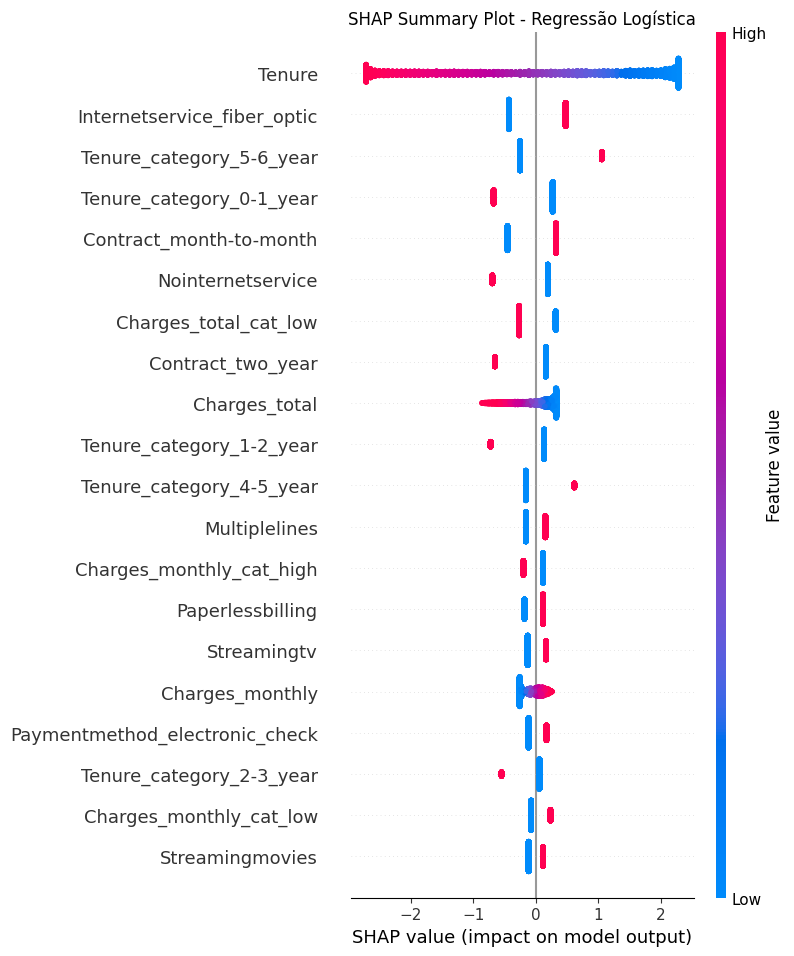

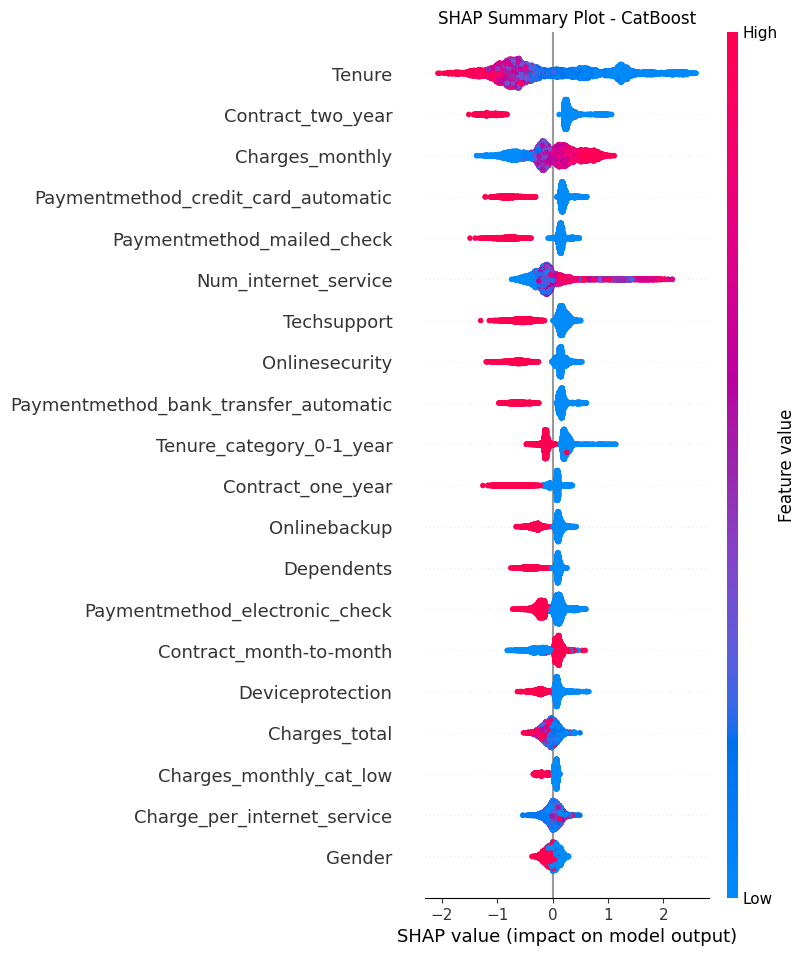

In [31]:
# Para a Regressão Logística
explainer_reglog = shap.Explainer(regressao_logistica, X_ab1_train)
shap_values_reglog = explainer_reglog(X_ab1_train)

# Gerar o gráfico para a Regressão Logística
shap.summary_plot(shap_values_reglog, X_ab1_train, show=False)
plt.title("SHAP Summary Plot - Regressão Logística")
plt.show()

# Para o CatBoost
explainer_catboost = shap.Explainer(catboost)
shap_values_catboost = explainer_catboost(X_ab2_train)

# Gerar o gráfico para o CatBoost
shap.summary_plot(shap_values_catboost, X_ab2_train, show=False)
plt.title("SHAP Summary Plot - CatBoost")
plt.show()